In [57]:
from neo4j import GraphDatabase, exceptions
import networkx as nx
from decouple import config
from functools import wraps
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
class Neo4jGraphGenerator:
    """
    Classe para gerar grafos a partir dos dados no Neo4j e para gerar grafos Erdos-Renyi (ER) e Small World (SW).
    """
    
    def __init__(self):
        """
        Inicializa a conexão com o banco de dados Neo4j usando informações do arquivo .env.
        """
        self.uri = config('NEO4J_URI')
        self.user = config('NEO4J_USERNAME')
        self.password = config('NEO4J_PASSWORD')
        self._driver = GraphDatabase.driver(self.uri, auth=(self.user, self.password))

    def close(self):
        """
        Fecha a conexão com o banco de dados Neo4j.
        """
        self._driver.close()

    def _handle_transient_error(self, e):
        """
        Manipula erros transitórios, como MemoryPoolOutOfMemoryError no Neo4j.
        """
        if "MemoryPoolOutOfMemoryError" in str(e):
            print("Erro: Limite de memória atingido. Tente novamente com uma carga de dados menor.")
        else:
            raise

    def _retry_on_transient_error(func):
        """
        Decorador para retry automático em caso de erro transitório.
        """
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            max_retries = 3
            for attempt in range(1, max_retries + 1):
                try:
                    return func(self, *args, **kwargs)
                except exceptions.TransientError as e:
                    if attempt == max_retries:
                        self._handle_transient_error(e)
                    else:
                        print(f"Transient error occurred. Retrying... (Attempt {attempt}/{max_retries})")

        return wrapper

    def _create_graph_from_neo4j(self):
        """
        Cria um grafo NetworkX a partir dos dados no Neo4j.
        """
        with self._driver.session() as session:
            query = """
            MATCH (n)
            RETURN id(n) as id, labels(n)[0] as label
            """
            result = session.run(query)
            nodes = [(record['id'], {'label': record['label']}) for record in result]

            query = """
            MATCH (a)-[r]->(b)
            RETURN id(a) as source, id(b) as target, type(r) as relationship
            """
            result = session.run(query)
            edges = [(record['source'], record['target'], {'relationship': record['relationship']}) for record in result]

            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)

            return G

    def _generate_er_graph(self, n, p):
        """
        Gera um grafo Erdos-Renyi (ER) usando o modelo NetworkX.
        """
        return nx.erdos_renyi_graph(n, p)

    def _generate_sw_graph(self, n, k, p):
        """
        Gera um grafo Small World (SW) usando o modelo NetworkX.
        """
        return nx.watts_strogatz_graph(n, k, p)

    def _generate_ba_graph(self, n, m):
        return nx.barabasi_albert_graph(n, m)

    def _timeit(func):
        """
        Decorador para medir o tempo de execução de um método.
        """
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time()
            result = func(*args, **kwargs)
            end_time = time()
            print(f"{func.__name__} execution time: {end_time - start_time} seconds")
            return result

        return wrapper

    @_retry_on_transient_error
    def generate_er_graph_from_neo4j(self, n, p):
        """
        Gera um grafo Erdos-Renyi (ER) a partir dos dados no Neo4j.
        """
        neo4j_graph = self._create_graph_from_neo4j()
        return self._generate_er_graph(n, p)

    @_retry_on_transient_error
    def generate_sw_graph_from_neo4j(self, n, k, p):
        """
        Gera um grafo Small World (SW) a partir dos dados no Neo4j.
        """
        neo4j_graph = self._create_graph_from_neo4j()
        return self._generate_sw_graph(n, k, p)
    
    @_retry_on_transient_error
    def generate_ba_graph_from_neo4j(self, n, m):
        neo4j_graph = self._create_graph_from_neo4j()
        return self._generate_ba_graph(n, m)

    @_timeit
    def generate_and_time_er_graph(self, n, p):
        """
        Gera e mede o tempo de execução de um grafo Erdos-Renyi (ER).
        """
        return self._generate_er_graph(n, p)

    @_timeit
    def generate_and_time_sw_graph(self, n, k, p):
        """
        Gera e mede o tempo de execução de um grafo Small World (SW).
        """
        return self._generate_sw_graph(n, k, p)
    
    @_timeit
    def generate_and_time_ba_graph(self, n, m):
        return self._generate_ba_graph(n, m)
    
    def _plot_growth(self, x_values, y_values, x_label, y_label, title):
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.grid(True)
        plt.show()

    def _calculate_ba_growth(self, n_values, m):
        growth_rates = []
        for n in n_values:
            ba_graph = self._generate_ba_graph(n, m)
            growth_rates.append(nx.average_shortest_path_length(ba_graph))

        return growth_rates

    def plot_ba_growth(self, max_n, m):
        n_values = list(range(m + 1, max_n + 1))
        growth_rates = self._calculate_ba_growth(n_values, m)

        # Configurações estéticas do Seaborn
        sns.set(style="whitegrid", palette="pastel", color_codes=True)
        plt.figure(figsize=(10, 6))

        # Plotagem da taxa de crescimento
        sns.lineplot(x=n_values, y=growth_rates, label='Taxa Média de Crescimento', marker='o')

        # Configurações adicionais do gráfico
        plt.title('Crescimento da Rede Barabási-Albert')
        plt.xlabel('Número de Nós (n)')
        plt.ylabel('Taxa Média de Crescimento')
        plt.legend()
        plt.show()

generate_and_time_er_graph execution time: 0.0032188892364501953 seconds
generate_and_time_sw_graph execution time: 0.0003821849822998047 seconds
generate_and_time_ba_graph execution time: 0.001089334487915039 seconds


/home/calendario2009/anaconda3/envs/base-conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/calendario2009/anaconda3/envs/base-conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/calendario2009/anaconda3/envs/base-conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/calendario2009/anaconda3/envs/base-conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

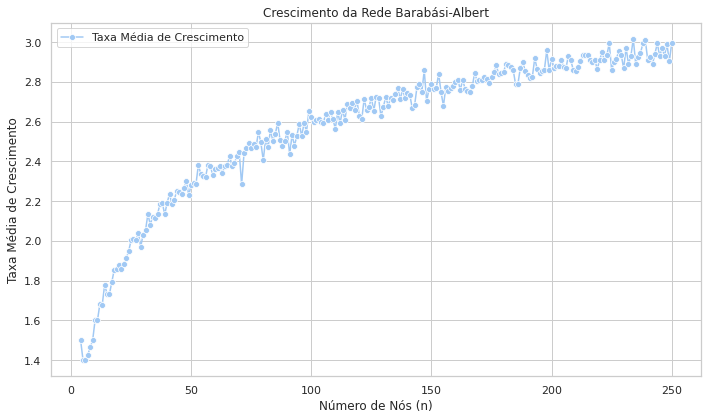

In [59]:
# Chama a classe
graph_generator = Neo4jGraphGenerator()

# Gera um grafo Erdos-Renyi (ER) a partir dos dados no Neo4j com 250 nós e probabilidade 0.1
er_graph_from_neo4j = graph_generator.generate_er_graph_from_neo4j(250, 0.1)

# Gera um grafo Small World (SW) a partir dos dados no Neo4j com 250 nós, 4 vizinhos próximos e probabilidade 0.1
sw_graph_from_neo4j = graph_generator.generate_sw_graph_from_neo4j(250, 4, 0.1)

# Gera um grafo de Barabási-Albert (BA) a partir dos dados no Neo4j com 250 nós e probabilidade 3
ba_graph_from_neo4j = graph_generator.generate_ba_graph_from_neo4j(250, 3)

# Gera e mede o tempo de execução de um grafo Erdos-Renyi (ER) com 250 nós e probabilidade 0.1
er_graph_and_time = graph_generator.generate_and_time_er_graph(250, 0.1)

# Gera e mede o tempo de execução de um grafo Small World (SW) com 250 nós, 4 vizinhos próximos e probabilidade 0.1
sw_graph_and_time = graph_generator.generate_and_time_sw_graph(250, 4, 0.1)

# Gera e mede o tempo de execução de um grafo Barabási-Albert (BA) com 250 nós e probabilidade 3
ba_graph_and_time = graph_generator.generate_and_time_ba_graph(250, 3)

# Gera uma Curva de Crescimento da Rede utilizando Barabási-Albert (BA)
graph_generator.plot_ba_growth(250, 3)

graph_generator.close()

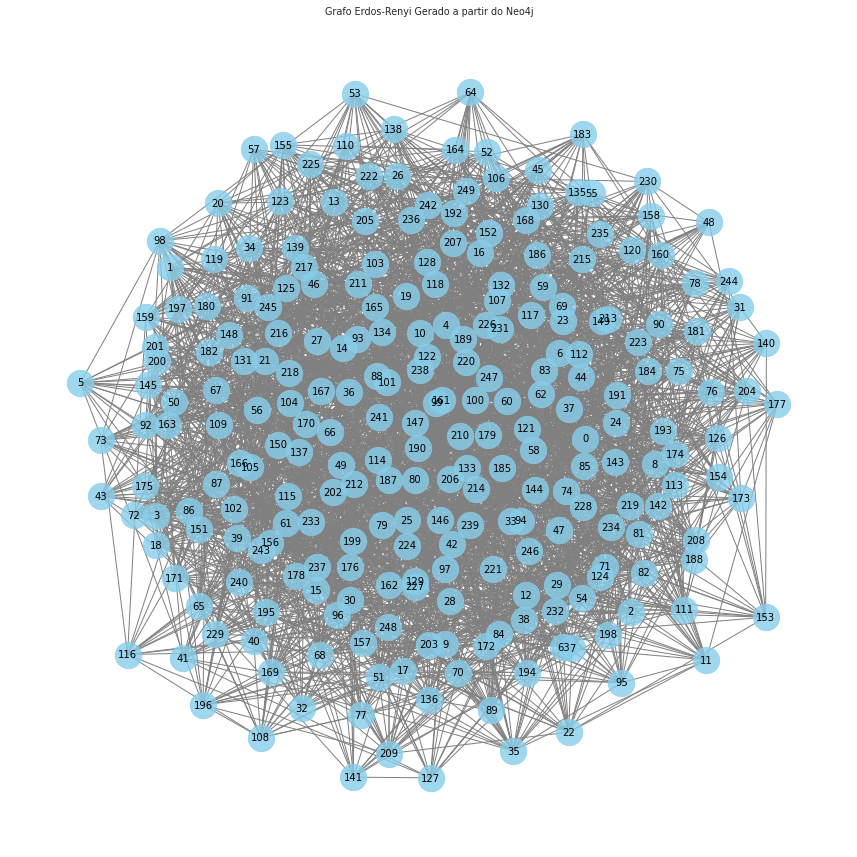

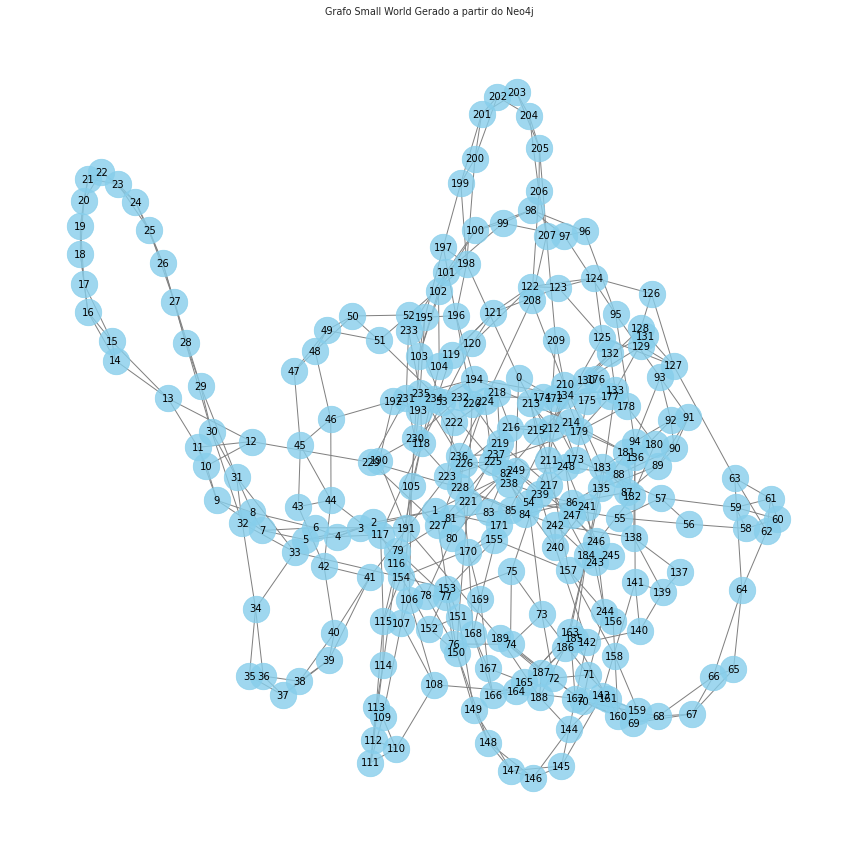

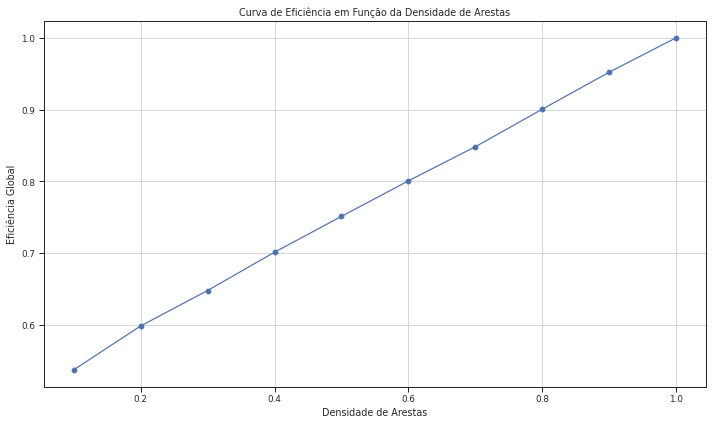

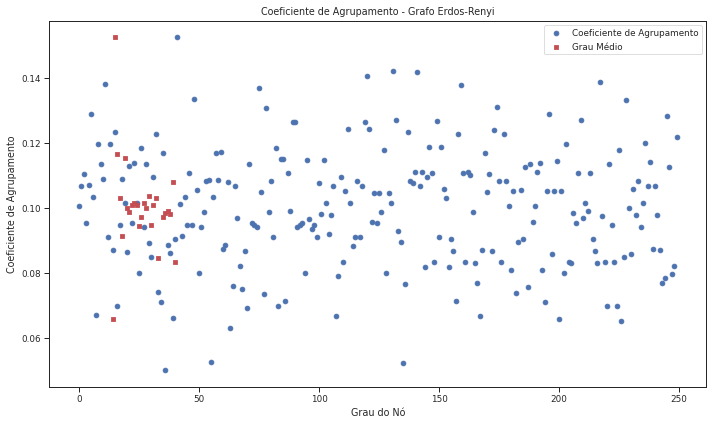

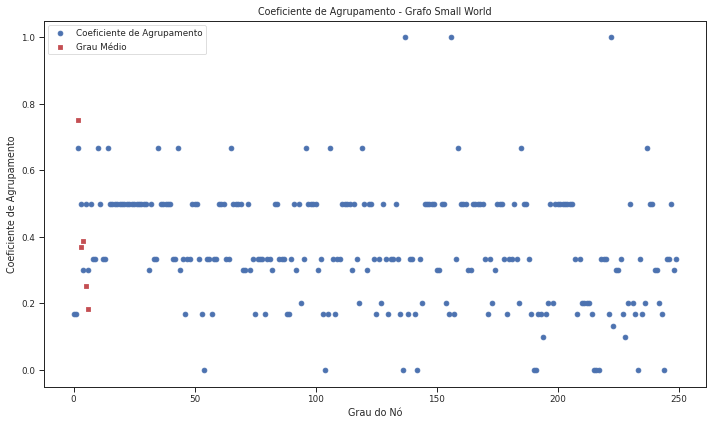

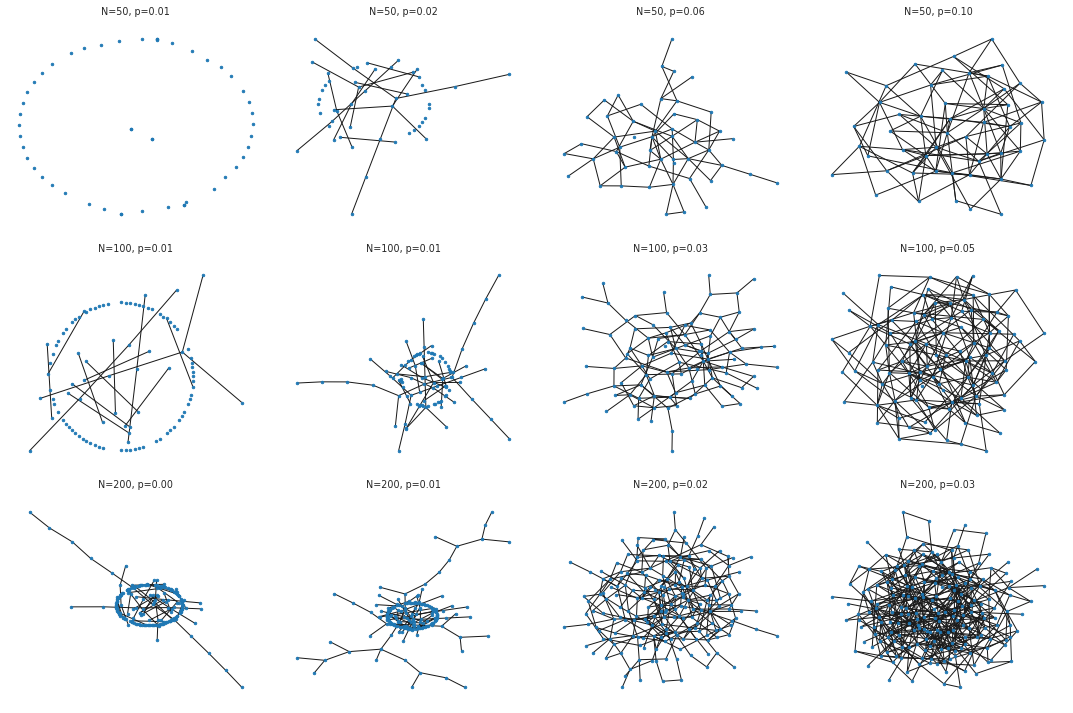

In [67]:
import sys
from pathlib import Path

# Procura o diretório raiz do projeto com o sys.path
sys.path.append(str(Path.cwd().parent))

from src.visualization.visualize import DataVisualization

data_visualization = DataVisualization()

# Visualizações
visualizacao = DataVisualization()

# Exemplo de uso
data_visualization.plot_graph_erdos_small(er_graph_from_neo4j, "Grafo Erdos-Renyi Gerado a partir do Neo4j")
data_visualization.plot_graph_erdos_small(sw_graph_from_neo4j, "Grafo Small World Gerado a partir do Neo4j")

densities, efficiencies = data_visualization.efficiency_curve_erdos_small(er_graph_from_neo4j)
data_visualization.plot_efficiency_curve_erdos_small(densities, efficiencies)

# Exemplo de uso
data_visualization.plot_clustering_coefficient_erdos_small(er_graph_from_neo4j, "Coeficiente de Agrupamento - Grafo Erdos-Renyi")
data_visualization.plot_clustering_coefficient_erdos_small(sw_graph_from_neo4j, "Coeficiente de Agrupamento - Grafo Small World")


n_vals = (50, 100, 200)
p_vals = list(map(lambda n: (0.5 / (n - 1), 1 / (n - 1), 3 / (n - 1), 5 / (n - 1)), n_vals))

data_visualization.plot_er_graph(n_vals, p_vals)